<a href="https://colab.research.google.com/github/Cristie-Lima/FruitsVeggies_ML_Aplicada1/blob/main/Projeto_Final_FruitsVeggies_v2_7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Projeto Final – Classificação de Frutas, Legumes e Verduras (v2.7.2)**  
**Base teórica:** Kelleher, John D.; Mac Namee, Brian; D’Arcy, Aoife (2020). *Fundamentals of Machine Learning for Predictive Data Analytics (2nd ed.).*

> **Equipe:** A. Cristiane R. Lima; Claudio Sampaio;

> [parece que Felipe Botero entrou em outro grupo;

> José Henrique Cavalcante apresentou dia 11.out (sábado) ao Prof. Fábio]




# 🔧 0. Preparação dos dados — **limpeza opcional** vs. **atualização de timestamps** (v2.6)

Para controlar de forma segura a preparação das pastas `train/`, `validation/` e `test/`, introduz-se um **parâmetro** que permite escolher entre:

- **`mode = "touch"` (recomendado / não destrutivo):** apenas **atualiza os timestamps** (`mtime/atime`) de todos os arquivos, **sem apagar nada**. Útil quando se deseja forçar a ordenação/recência sem reextrair os dados.
- **`mode = "reextract"` (destrutivo e completo):** **remove** o conteúdo das pastas e **reextrai** os arquivos diretamente de `train.zip`, `validation.zip` e `test.zip` (se presentes). Garante consistência total, mas é mais custoso.

> **Sugestão:** utilizar `mode = "touch"` como padrão (mais seguro para não corromper o dataset), e recorrer a `reextract` quando houver suspeita de estrutura incorreta ou resíduos.


> **Atualização (v2.7):** adota-se um parâmetro de execução com dois modos — `mode = "touch"` (atualiza timestamps, **não destrutivo**) e `mode = "reextract"` (limpa e reextrai dos ZIPs, **destrutivo**); e uma *flag* `dry_run = True` para simulação sem alterações.

In [ ]:

# @title Preparação dos dados — modo 'touch' (seguro) ou 'reextract' (completo) + DRY RUN
import os, time, shutil

# === CONFIGURAÇÃO ===
BASE_DIR_DATA = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"  # local dos zips e das pastas train/validation/test
mode = "touch"        # opções: "touch" (não destrutivo) | "reextract" (destrutivo)
dry_run = False       # True: simula sem alterar; False: executa

splits = ["train", "validation", "test"]
zip_paths = {s: os.path.join(BASE_DIR_DATA, f"{s}.zip") for s in splits}

def touch_all(root):
    now = time.time(); total = 0
    for subdir, _, files in os.walk(root):
        for f in files:
            fp = os.path.join(subdir, f)
            if dry_run:
                print("[DRY] tocaria:", fp); total += 1; continue
            try:
                os.utime(fp, (now, now)); total += 1
            except Exception as e:
                print("Erro utime:", fp, e)
    return total

def clean_and_reextract(base_dir):
    for s in splits:
        target = os.path.join(base_dir, s)
        if os.path.exists(target):
            if dry_run: print(f"[DRY] removeria: {target}")
            else: shutil.rmtree(target)
        if dry_run: print(f"[DRY] criaria: {target}")
        else: os.makedirs(target, exist_ok=True)
    for s in splits:
        zpath = zip_paths[s]; target = os.path.join(base_dir, s)
        if os.path.exists(zpath):
            cmd = f'unzip -q "{zpath}" -d "{target}"'
            if dry_run: print(f"[DRY] executaria:", cmd)
            else:
                exit_code = os.system(cmd)
                if exit_code != 0: print(f"⚠️ Falha ao extrair {zpath} (exit={exit_code})")
        else:
            print(f"⚠️ ZIP não encontrado para {s}: {zpath}")

print("BASE_DIR_DATA:", BASE_DIR_DATA, "| mode:", mode, "| dry_run:", dry_run)
if mode == "touch":
    total = 0
    for s in splits:
        folder = os.path.join(BASE_DIR_DATA, s)
        if not os.path.isdir(folder):
            print("⚠️ Pasta inexistente (pulando):", folder); continue
        total += touch_all(folder)
    print(f"✅ Concluído — timestamps {'(simulados) ' if dry_run else ''}atualizados em {total:,} arquivos.")
elif mode == "reextract":
    clean_and_reextract(BASE_DIR_DATA)
    print(f"✅ Concluído — pastas {'(simuladas) ' if dry_run else ''}limpas e {'(simuladas) ' if dry_run else ''}reextraídas dos ZIPs.")
else:
    print("⚠️ Modo inválido. Use 'touch' ou 'reextract'.")


BASE_DIR_DATA: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies | mode: touch | dry_run: False
⚠️ Pasta inexistente (pulando): /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train
⚠️ Pasta inexistente (pulando): /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/validation
⚠️ Pasta inexistente (pulando): /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/test
✅ Concluído — timestamps atualizados em 0 arquivos.


### Verificação de estrutura (árvore de diretórios e contagem de imagens)

In [ ]:

# Lista a árvore de diretórios e conta imagens por split e por classe
import os, glob

DRIVE_BASE = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"
print("BASE_DIR_DATA:", DRIVE_BASE)

def list_tree(root, max_files=5):
    for subdir, dirs, files in os.walk(root):
        level = subdir.replace(root, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}📁 {os.path.basename(subdir) or subdir}")
        shown = 0
        for f in files:
            if shown >= max_files: break
            print(f"{indent}  └── {f}")
            shown += 1

def count_images(split):
    exts = ('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp')
    split_dir = os.path.join(DRIVE_BASE, split)
    total = 0
    per_class = {}
    if not os.path.isdir(split_dir):
        return total, per_class
    for cls in sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir,d))]):
        cls_dir = os.path.join(split_dir, cls)
        n = sum(1 for p in glob.glob(os.path.join(cls_dir, '**', '*'), recursive=True) if p.lower().endswith(exts))
        per_class[cls] = n; total += n
    return total, per_class

print("\nÁrvore resumida (primeiros arquivos por pasta):")
list_tree(DRIVE_BASE)

for split in ["train","validation","test"]:
    if os.path.isdir(os.path.join(DRIVE_BASE, split)):
        tot, per = count_images(split)
        print(f"\n[{split}] Total de imagens: {tot}")
        # Mostra até 10 classes com contagens
        klist = list(per.keys())[:10]
        for k in klist:
            print(f"  - {k}: {per[k]}")


BASE_DIR_DATA: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies

Árvore resumida (primeiros arquivos por pasta):



## Sumário
0. Introdução e formulação do problema  
1. Ingestão de dados (três arquivos ZIP) e organização das pastas  
1.1 Criação das subpastas e verificação dos arquivos ZIP  
1.2 Estrutura esperada do diretório após a extração  
1.3 Descompactação recursiva e organização automática  
1.4 Diagnóstico da estrutura e verificação de pastas de classes  
1.5 Detecção automática das raízes de classes e contagem de imagens  
2. Preparação e engenharia de atributos (*feature engineering*)  
3. Modelagem conforme Plano de Ensino (KNN, Árvore, Regressão Logística, Random Forest, Bagging, Boosting) + MLP

    **>> Professor sugeriu focar no MLP, kNN, Random Forest pois são os mais adequados para Classificar Imagens; Equipe: fazer double-checking se embedding está sendo aplicado apropriadamente**
4. Avaliação e *benchmarking* (matriz de confusão, métricas, *cross-validation* estratificada)  
5. Empacotamento do melhor modelo e *stub* de aplicativo Streamlit  
6. Conclusões, *trade-offs* (compensações) e trabalhos futuros  
7. Referências



## 0. Introdução e formulação do problema

Observou-se que o objetivo consiste em **classificar imagens** de frutas, legumes e verduras em suas respectivas categorias, utilizando modelos de **aprendizado supervisionado**. Pretende-se fundamentar cada etapa no arcabouço proposto por Kelleher (2ª ed.), contemplando definição do problema, preparação dos dados, modelagem, avaliação e implantação (*deployment*) simplificada via aplicativo.

**Pergunta de pesquisa:** É possível treinar um modelo supervisionado que classifique corretamente, a partir de **atributos extraídos de imagens** (*image features*), as classes de interesse?

**Tipo de tarefa:** Classificação **multiclasse**.

**Objetivo prático:** Disponibilizar um **aplicativo interativo** (Streamlit) que receba uma imagem e retorne a predição do modelo.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Pasta no Google Drive:

> Pode-se adaptar para usar direto na content, mas sempre será perdida a estrutura descompactada de arquivos; por isto, optou-se por criar no drive pessoal uma vez só; _**então só basta executar uma vez o item 1.1**_

In [ ]:
# @title Chave para pular (SKIP = 1) ou não (SKIP = 0) a Extração de Imagens em Subpastas (Seção 1.1)
# 0: NÃO PULAR, para extrair sempre que estiver configurado SKIP=0
# 1: PULAR, se já houver extraído para o Google Drive pessoal

SKIP = 1


import os, zipfile, glob

BASE_DIR = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"
SUBFOLDERS = ["validation", "test", "train"]

TRAIN_ZIP = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train.zip"
TRAIN_DIR = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train"




## 1. Ingestão de dados (três arquivos ZIP) e organização das pastas

**_Obs._: Como está sendo feito cópia no drive pessoal relativo MyDrive, não há necessidade de re-executar para descompactar.**

## 1.1 Criação das subpastas e verificação dos arquivos ZIP

Deve-se salvar os três arquivos `train.zip`, `validation.zip` e `test.zip` na pasta **`data_FruitsVegs`** da pasta **`/content/drive/MyDrive/`** do Google Colab.  
Em seguida, criam-se automaticamente as subpastas correspondentes (`train/`, `validation/` e `test/`) que irão conter os arquivos descompactados, garantindo a estrutura hierárquica adequada para a detecção de classes.


In [ ]:
# @title Descompactação de validation.zip e test.zip
#SKIP = 1
if not SKIP:
  import os, zipfile, glob

  def unzip_quick(zip_path, dest_path):
      if not os.path.exists(zip_path):
          print(f"⚠️ Arquivo ausente: {zip_path}; por gentileza, fazer o 'upload' do arquivo para a respectiva pasta")
          return
      os.makedirs(dest_path, exist_ok=True)
      print(f"📦 Extraindo {os.path.basename(zip_path)} → {dest_path}")
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          zip_ref.extractall(dest_path)
      print(f"✓ Extração concluída: {len(glob.glob(os.path.join(dest_path, '**', '*.*'), recursive=True))} arquivos.")

  for sub in SUBFOLDERS:
      zip_file = os.path.join(BASE_DIR, f"{sub}.zip")
      dest = os.path.join(BASE_DIR, sub)
      unzip_quick(zip_file, dest)

In [ ]:
# @title Descompactação segura de train.zip (streaming e progressiva)
#SKIP = 1
if not SKIP:
  import zipfile, os
  from tqdm import tqdm  # barra de progresso

  if not os.path.exists(TRAIN_ZIP):
      print("⚠️ train.zip não encontrado.")
  else:
      os.makedirs(TRAIN_DIR, exist_ok=True)
      with zipfile.ZipFile(TRAIN_ZIP, 'r') as zip_ref:
          files = zip_ref.namelist()
          print(f"📦 Extraindo {len(files)} arquivos de train.zip para {TRAIN_DIR} ...")
          for f in tqdm(files, desc="Extraindo", ncols=100):
              try:
                  zip_ref.extract(f, TRAIN_DIR)
              except Exception as e:
                  print("Erro ao extrair:", f, e)
      print("✓ Descompactação de train.zip concluída.")



## 1.2 Estrutura esperada do diretório após a extração

Após a descompactação, a estrutura de diretórios deve seguir o formato abaixo, onde cada subpasta representa uma classe de frutas ou vegetais. O nome da subpasta corresponde ao **rótulo da classe** (label) utilizado no treinamento e avaliação.

```
/content/data_FruitsVegs/
├── train/
│   ├── Apple/
│   ├── Banana/
│   ├── Carrot/
│   └── ...
├── validation/
│   ├── Apple/
│   ├── Banana/
│   ├── Carrot/
│   └── ...
└── test/
    ├── Apple/
    ├── Banana/
    ├── Carrot/
    └── ...
```



### 1.3 Diagnóstico da estrutura e verificação de pastas de classes

Após a extração, realiza-se uma inspeção da árvore de diretórios para confirmar a presença das subpastas de classes (ex.: `Apple`, `Banana`, `Carrot`, etc.) em cada conjunto (`train`, `validation`, `test`). Esse diagnóstico confirma que os dados estão prontos para extração de atributos (*feature extraction*).


In [ ]:










# @title Diagnóstico da estrutura (visualização parcial)
import pathlib

def print_tree(root, max_depth=2, prefix=""):
    root = pathlib.Path(root)
    if max_depth < 0:
        return
    entries = sorted(list(root.iterdir()))
    for e in entries[:60]:
        print(prefix + ("📁 " if e.is_dir() else "📄 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print("=== Estrutura parcial de", BASE_DIR, "===")
print_tree(BASE_DIR, max_depth=2)


=== Estrutura parcial de /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies ===
📁 _projeto
   📁 .ipynb_checkpoints
   📄 Projeto_Final_FruitsVeggies_v2.3.ipynb
   📄 Projeto_Final_FruitsVeggies_v2.4.ipynb
   📄 Projeto_Final_FruitsVeggies_v2.6.1.ipynb
   📄 Projeto_Final_FruitsVeggies_v2.7.1_consolidado_paths.ipynb
   📄 Projeto_Final_FruitsVeggies_v2.7.2.ipynb
   📄 Projeto_Final_FruitsVeggies_v2.7.3_fruit_veg_TL_streamlit.ipynb
   📄 Projeto_Final_FruitsVeggies_v2.7_unificado.ipynb
   📄 Projeto_Final_FruitsVeggies_v2.8.ipynb
📁 app
   📄 app_Fruits_Veggies_streamlit_stub.py
📁 images_from_internet
   📄 Herbs.jpg
   📄 Herbs2.jpg
   📄 Turnips_Rutabagas_KYC_Feat_Image.jpg
   📄 beans_and_legumes.jpg
   📄 broccoli.jpg
   📄 cauliflower_1.jpg
   📄 cauliflower_2.jpg
   📄 coloured_turnips.jpg
   📄 common root vegetables.jpg
   📄 daikon_raddish.jpg
   📄 daikon_radishes.png
   📄 few_sweet_potatoes.jpg
   📄 french_raddishes.png
   📄 ginger.jpg
   📄 ginger_plant.jpg
   📄 green vegetables.jpg
   📄 lo


### 1.4 Detecção automática das raízes de classes e contagem de imagens

Implementa-se um método de **detecção automática da raiz de classes**, que identifica onde estão as pastas correspondentes aos rótulos (labels). Em seguida, realiza-se a contagem do total de imagens em cada conjunto (`train`, `validation`, `test`).


In [ ]:

# @title Detecção automática das raízes de classes e contagem de imagens
import os, glob

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

def find_class_root(root):
    best, best_score = None, -1
    for p, dirs, files in os.walk(root):
        subdirs = [os.path.join(p, d) for d in dirs]
        score = 0
        for sd in subdirs:
            imgs = glob.glob(os.path.join(sd, "*"))
            if any(str(x).lower().endswith(IMG_EXTS) for x in imgs):
                score += 1
        if score >= 3 and score > best_score:
            best = p
            best_score = score
    return best

roots = {}
for split in SUBFOLDERS:
    cand = find_class_root(os.path.join(BASE_DIR, split))
    roots[split] = cand if cand else None
    print(f"📂 Raiz detectada para {split}: {roots[split]}")

def list_images(root):
    if not root or not os.path.isdir(root):
        return []
    return [p for p in glob.glob(os.path.join(root, '**', '*'), recursive=True)
            if p.lower().endswith(IMG_EXTS)]

imgs = {split: list_images(roots[split]) for split in roots}

for split, lst in imgs.items():
    print(f"{split}: {len(lst)} imagens")
    if lst:
        print("Exemplo:", lst[0])


📂 Raiz detectada para validation: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/validation
📂 Raiz detectada para test: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/test
📂 Raiz detectada para train: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train
validation: 351 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/validation/apple/Image_1.jpg
test: 359 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/test/apple/Image_1.jpg
train: 3115 imagens
Exemplo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/train/apple/Image_1.jpg



## 2. Preparação e engenharia de atributos (*feature engineering*)

Foram extraídos **atributos de cor** (média RGB) e **descritores de textura/forma** via **HOG (Histogram of Oriented Gradients – histograma de gradientes orientados)**. Em seguida, aplicou-se **normalização** (*scaling*).


In [ ]:

# @title Extração de atributos (RGB + HOG) e preparação dos conjuntos (Duração: 7~35min)
import cv2, numpy as np, os
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def read_image(path, size=(128,128)):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

def rgb_mean_feature(img):
    return img.mean(axis=(0,1))

def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feat = hog(
        gray, orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys', transform_sqrt=True, feature_vector=True
    )
    return feat

def parent_label(p):
    return os.path.basename(os.path.dirname(p))

def build_Xy(file_list):
    X_rgb, X_hog, y = [], [], []
    for p in file_list:
        img = read_image(p)
        if img is None:
            continue
        X_rgb.append(rgb_mean_feature(img))
        X_hog.append(hog_feature(img))
        y.append(parent_label(p))
    X = np.hstack([np.array(X_rgb), np.array(X_hog)])
    y = np.array(y)
    return X, y

trainval_files = (imgs.get("train", []) or []) + (imgs.get("validation", []) or [])
assert len(trainval_files) > 0, "Não foram encontradas imagens em train/validation. Checar estrutura."
X_trainval, y_trainval = build_Xy(trainval_files)
print("Train+Val -> X:", X_trainval.shape, "y:", y_trainval.shape)

X_test_ext, y_test_ext = (None, None)
if len(imgs.get("test", [])) > 0:
    X_test_ext, y_test_ext = build_Xy(imgs["test"])
    print("Test externo -> X:", X_test_ext.shape, "y:", y_test_ext.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.30, random_state=42, stratify=y_trainval
)
print("Split 70/30 -> X_train:", X_train.shape, "X_valid:", X_valid.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
if X_test_ext is not None:
    X_test_ext = scaler.transform(X_test_ext)


Train+Val -> X: (3465, 8103) y: (3465,)
Test externo -> X: (359, 8103) y: (359,)
Split 70/30 -> X_train: (2425, 8103) X_valid: (1040, 8103)


# Se a Modelagem já tiver sido salva, pode-se pular os tópicos de 3 a 5


## 3. Modelagem conforme Plano de Ensino + MLP  (Duração: ~10min)

Atendendo ao Plano de Ensino, implementaram-se os seguintes modelos (**scikit-learn**):  
**KNN (k-vizinhos mais próximos), Árvore de Decisão, Regressão Logística (multiclasse), Random Forest (floresta aleatória), Bagging (agregação por *bootstrap*) com árvore base, Boosting (AdaBoost)** e **MLP (rede neural multicamada)** como adicional.

Obs.: Somente usados efetivamente os 3 modelos recomendados pelo Professor: kNN, Random Forest e MLP. Demais estão comentados.


In [ ]:
# @title == Modelos clássicos com compatibilidade de versão (scikit-learn 0.24→1.5+) ==
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Helper para manter compatibilidade entre 'estimator' (novo) e 'base_estimator' (antigo)
def _compat_param(estimator_cls, new='estimator', old='base_estimator'):
    try:
        params = estimator_cls().get_params()
        return new if new in params else old
    except Exception:
        # Se algo impedir get_params(), assume API nova
        return new

bag_param = _compat_param(BaggingClassifier)
ada_param = _compat_param(AdaBoostClassifier)

models = {
    #"Árvore de Decisão": DecisionTreeClassifier(max_depth=None, random_state=42),
    #"Regressão Logística": LogisticRegression(max_iter=1000, solver="lbfgs", n_jobs=-1),
    #"Bagging (agregação por bootstrap)": BaggingClassifier(
    #    **{
    #        bag_param: DecisionTreeClassifier(random_state=42),
    #        "n_estimators": 100,
    #        "random_state": 42,
    #        "n_jobs": -1
    #    }
    #),
    #"Boosting (AdaBoost)": AdaBoostClassifier(
    #    **{
    #        ada_param: DecisionTreeClassifier(max_depth=2, random_state=42),
    #        "n_estimators": 200,
    #        "learning_rate": 0.5,
    #        "random_state": 42
    #    }
    #),
    "KNN (k-vizinhos mais próximos)": KNeighborsClassifier(n_neighbors=7, weights='distance'),
    "Random Forest (floresta aleatória)": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "MLP (rede neural multicamada)": MLPClassifier(
        hidden_layer_sizes=(128,),
        activation='relu',
        max_iter=200,
        random_state=42 # Ref. de "O Guia do Mochileiro das Galáxias"
    ),
}

fitted = {}
for name, clf in models.items():
    print(f"Treinando: {name}")
    fitted[name] = clf.fit(X_train, y_train)
print("Concluído.")


Treinando: KNN (k-vizinhos mais próximos)
Treinando: Random Forest (floresta aleatória)
Treinando: MLP (rede neural multicamada)
Concluído.



## 4. Avaliação e *benchmarking* (Duração: ~49min)

Relatam-se métricas no **conjunto de validação (30%)** e, se disponível, no **teste externo**. Em seguida, executa-se **validação cruzada estratificada** (5-fold) sobre `train+val`. As métricas utilizadas são **acurácia** (*accuracy*) e **F1-macro**.



=== KNN (k-vizinhos mais próximos) @ valid(30%) ===
Acurácia (accuracy): 0.2952
F1-macro: 0.3401

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.53      0.39      0.45        23
       banana       0.92      0.48      0.63        25
     beetroot       0.64      0.24      0.35        29
  bell pepper       0.75      0.20      0.32        30
      cabbage       0.33      0.16      0.22        31
     capsicum       0.60      0.20      0.30        30
       carrot       0.61      0.52      0.56        27
  cauliflower       0.33      0.30      0.31        27
chilli pepper       0.62      0.17      0.27        29
         corn       0.37      0.24      0.29        29
     cucumber       0.64      0.23      0.33        31
     eggplant       1.00      0.29      0.44        28
       garlic       0.88      0.23      0.36        31
       ginger       0.83      0.22      0.34        23
       grapes       0.4

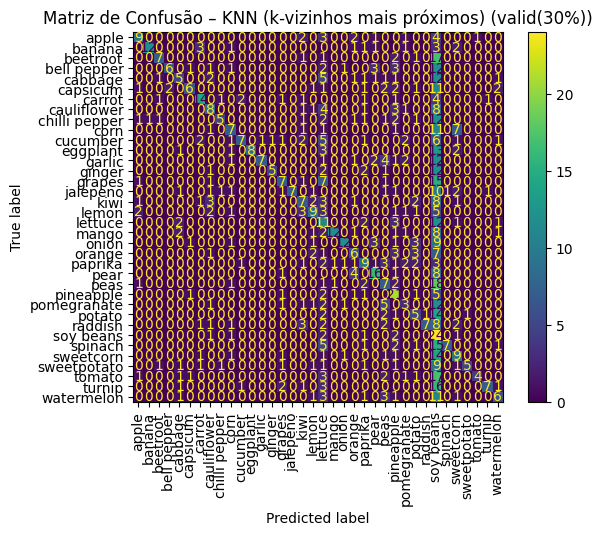


=== Random Forest (floresta aleatória) @ valid(30%) ===
Acurácia (accuracy): 0.3452
F1-macro: 0.3491

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.60      0.39      0.47        23
       banana       0.44      0.60      0.51        25
     beetroot       0.39      0.31      0.35        29
  bell pepper       0.38      0.27      0.31        30
      cabbage       0.27      0.29      0.28        31
     capsicum       0.44      0.23      0.30        30
       carrot       0.38      0.56      0.45        27
  cauliflower       0.30      0.41      0.34        27
chilli pepper       0.25      0.10      0.15        29
         corn       0.27      0.28      0.27        29
     cucumber       0.31      0.32      0.32        31
     eggplant       0.20      0.39      0.26        28
       garlic       0.29      0.29      0.29        31
       ginger       0.83      0.22      0.34        23
       grapes      

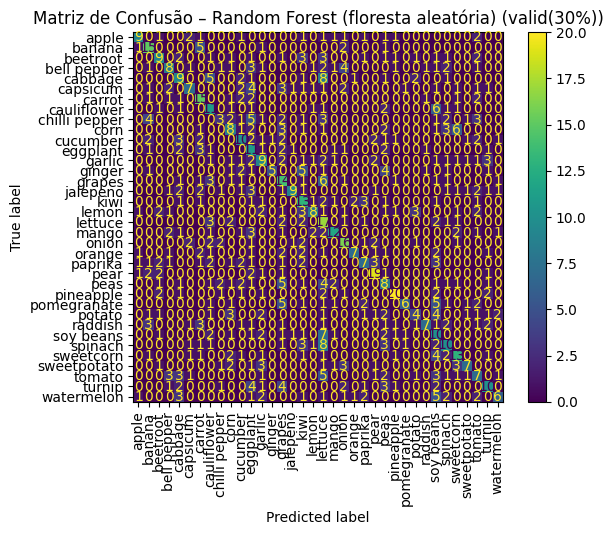


=== MLP (rede neural multicamada) @ valid(30%) ===
Acurácia (accuracy): 0.3163
F1-macro: 0.3152

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       0.44      0.35      0.39        23
       banana       0.48      0.60      0.54        25
     beetroot       0.32      0.28      0.30        29
  bell pepper       0.33      0.33      0.33        30
      cabbage       0.30      0.32      0.31        31
     capsicum       0.35      0.23      0.28        30
       carrot       0.57      0.48      0.52        27
  cauliflower       0.30      0.41      0.34        27
chilli pepper       0.25      0.14      0.18        29
         corn       0.27      0.31      0.29        29
     cucumber       0.31      0.32      0.32        31
     eggplant       0.34      0.39      0.37        28
       garlic       0.33      0.35      0.34        31
       ginger       0.40      0.26      0.32        23
       grapes       0.26

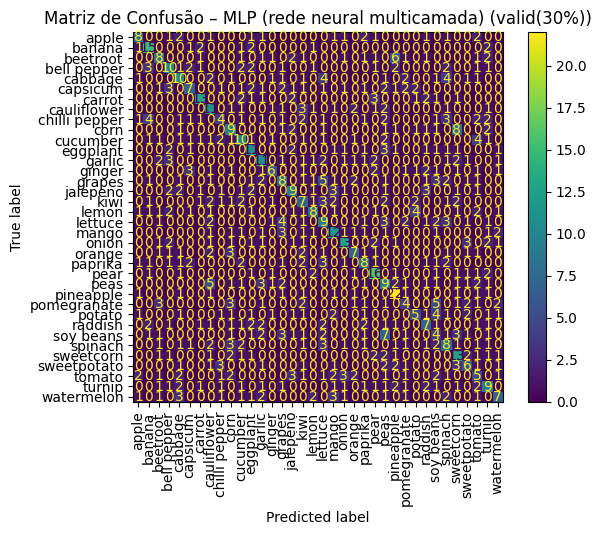


=== KNN (k-vizinhos mais próximos) @ test externo ===
Acurácia (accuracy): 0.9359
F1-macro: 0.9401

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       1.00      0.89      0.94         9
     beetroot       1.00      0.90      0.95        10
  bell pepper       0.90      0.90      0.90        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.80      0.89        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      0.90      0.95        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      0.90      0.95        10
       grapes       1

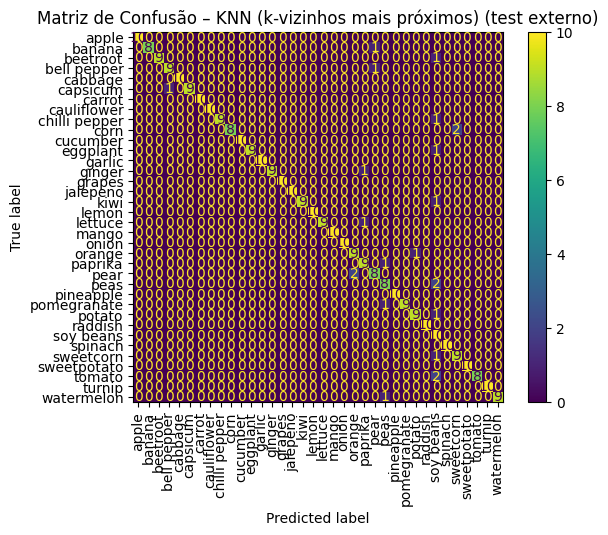


=== Random Forest (floresta aleatória) @ test externo ===
Acurácia (accuracy): 0.9443
F1-macro: 0.9445

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       1.00      1.00      1.00         9
     beetroot       0.90      0.90      0.90        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       0.91      1.00      0.95        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      1.00      1.00        10
  cauliflower       0.91      1.00      0.95        10
chilli pepper       1.00      0.90      0.95        10
         corn       0.89      0.80      0.84        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      0.90      0.95        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      0.90      0.95        10
       grapes    

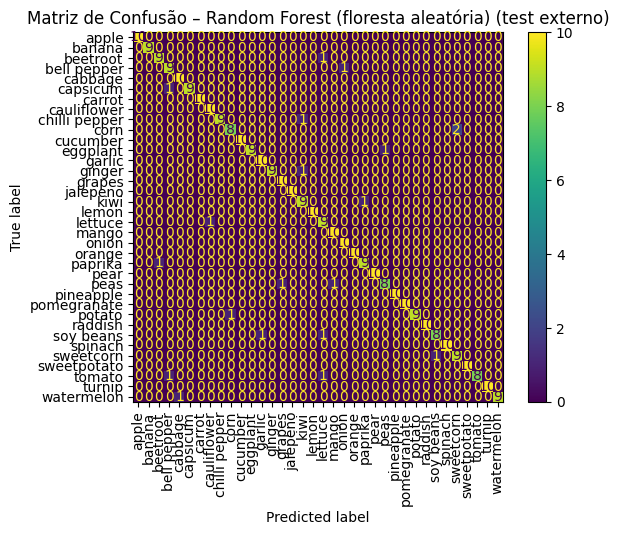


=== MLP (rede neural multicamada) @ test externo ===
Acurácia (accuracy): 0.9415
F1-macro: 0.9412

Relatório de classificação (classification report):
               precision    recall  f1-score   support

        apple       1.00      1.00      1.00        10
       banana       0.90      1.00      0.95         9
     beetroot       0.90      0.90      0.90        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       0.91      1.00      0.95        10
     capsicum       0.90      0.90      0.90        10
       carrot       1.00      1.00      1.00        10
  cauliflower       0.91      1.00      0.95        10
chilli pepper       1.00      0.90      0.95        10
         corn       1.00      0.80      0.89        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      0.90      0.95        10
       garlic       0.83      1.00      0.91        10
       ginger       1.00      0.90      0.95        10
       grapes       1.

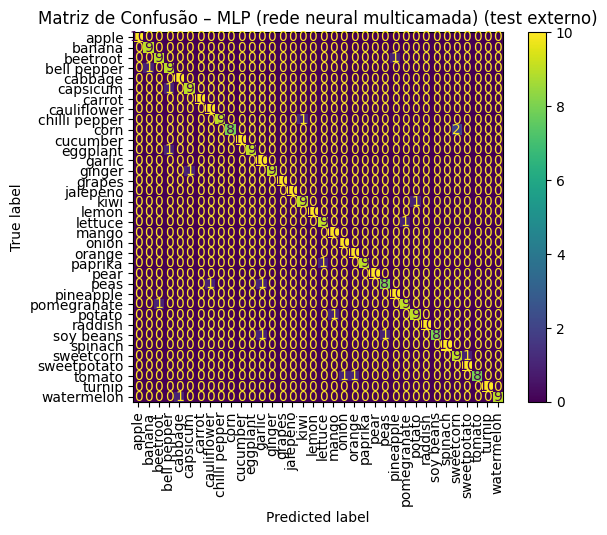


=== Tabela de validação (30%) ===


,acc_valid,f1_valid
Random Forest (floresta aleatória),0.345192,0.349063
KNN (k-vizinhos mais próximos),0.295192,0.340126
MLP (rede neural multicamada),0.316346,0.315189



=== Tabela de teste externo ===


,acc_test,f1_test
Random Forest (floresta aleatória),0.944290,0.944536
MLP (rede neural multicamada),0.941504,0.941195
KNN (k-vizinhos mais próximos),0.935933,0.940146


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,acc_mean,acc_std,f1_mean,f1_std
Random Forest (floresta aleatória),0.341703,0.021527,0.339111,0.021420
KNN (k-vizinhos mais próximos),0.299567,0.016991,0.338874,0.023460
MLP (rede neural multicamada),0.321501,0.020293,0.318650,0.020238


In [ ]:
# @title == Relatórios de classificação ==

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def evaluate_split(name, clf, X, y, split_name):
    y_hat = clf.predict(X)
    acc = accuracy_score(y, y_hat)
    f1m = f1_score(y, y_hat, average='macro')
    print(f"\n=== {name} @ {split_name} ===")
    print("Acurácia (accuracy):", f"{acc:.4f}")
    print("F1-macro:", f"{f1m:.4f}")
    print("\nRelatório de classificação (classification report):")
    print(classification_report(y, y_hat))
    cm = confusion_matrix(y, y_hat, labels=np.unique(y))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(xticks_rotation=90)
    plt.title(f"Matriz de Confusão – {name} ({split_name})")
    plt.show()
    return acc, f1m

results_valid = {}
for name, clf in fitted.items():
    acc, f1m = evaluate_split(name, clf, X_valid, y_valid, "valid(30%)")
    results_valid[name] = {"acc_valid": acc, "f1_valid": f1m}

results_test = {}
if 'X_test_ext' in globals() and X_test_ext is not None and y_test_ext is not None:
    for name, clf in fitted.items():
        acc, f1m = evaluate_split(name, clf, X_test_ext, y_test_ext, "test externo")
        results_test[name] = {"acc_test": acc, "f1_test": f1m}

print("\n=== Tabela de validação (30%) ===")
df_valid = pd.DataFrame(results_valid).T.sort_values(by=["f1_valid","acc_valid"], ascending=False)
display(df_valid)

if results_test:
    print("\n=== Tabela de teste externo ===")
    df_test = pd.DataFrame(results_test).T.sort_values(by=["f1_test","acc_test"], ascending=False)
    display(df_test)

from numpy import vstack, hstack
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"accuracy":"accuracy", "f1_macro":"f1_macro"}
cv_table = {}
for name, clf in models.items():
    scores = cross_validate(clf, vstack([X_train, X_valid]), hstack([y_train, y_valid]),
                            cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    cv_table[name] = {
        "acc_mean": scores["test_accuracy"].mean(),
        "acc_std":  scores["test_accuracy"].std(),
        "f1_mean":  scores["test_f1_macro"].mean(),
        "f1_std":   scores["test_f1_macro"].std()
    }

df_cv = pd.DataFrame(cv_table).T.sort_values(by=["f1_mean","acc_mean"], ascending=False)
display(df_cv)


## 5. Empacotamento do melhor modelo e *stub* de aplicativo Streamlit

Para implantação simples, recomenda-se salvar o **normalizador** (*scaler*) e o **melhor modelo** (critério por F1-macro) usando `joblib`. O *stub* do Streamlit ilustra o fluxo **upload → extração de atributos → predição**.


In [ ]:
# @title Seleção do melhor modelo (F1-macro) e salvamento no Google Drive
import joblib, os

# Determina o melhor modelo com base no F1 da validação
best_name = max(results_valid, key=lambda k: results_valid[k]["f1_valid"])
best_model = fitted[best_name]
print("Melhor modelo (validação F1-macro):", best_name, "->", results_valid[best_name])

# Caminho alvo no Google Drive
models_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models"
os.makedirs(models_path, exist_ok=True)

# Caminhos completos de destino
scaler_path = os.path.join(models_path, "scaler.joblib")
model_path = os.path.join(models_path, "best_model.joblib")

# Salvamento dos artefatos
joblib.dump(scaler, scaler_path)
joblib.dump(best_model, model_path)

print(f"✅ Artefatos salvos com sucesso em:\n{models_path}")



Melhor modelo (validação F1-macro): Random Forest (floresta aleatória) -> {'acc_valid': 0.3451923076923077, 'f1_valid': 0.3490630717495844}
✅ Artefatos salvos com sucesso em:
/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models


# 🧪 Modo silencioso — teste sem interface Streamlit (

In [ ]:
# @title Verifica que os arquivos dos modelos estão no Google Drive
import os

models_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models"
for f in os.listdir(models_path):
    print("📄", f, f"({os.path.getsize(os.path.join(models_path, f))/1024:.1f} KB)")


📄 best_model.joblib (179669.3 KB)
📄 best_model_pipeline.joblib (179859.8 KB)
📄 metadata.json (0.8 KB)
📄 scaler.joblib (190.5 KB)


In [ ]:
"""
# @title Teste silencioso da pipeline de predição (sem Streamlit)
import joblib, cv2, numpy as np
from skimage.feature import hog
from PIL import Image

# Carrega os artefatos
scaler = joblib.load(os.path.join(models_path, "scaler.joblib"))
model  = joblib.load(os.path.join(models_path, "best_model.joblib"))

# Funções de feature extraction
def rgb_mean_feature(img):
    return img.mean(axis=(0,1))

def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feat = hog(
        gray, orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys', transform_sqrt=True, feature_vector=True
    )
    return feat

# Caminho de uma imagem para teste
# (substitui pelo caminho de uma imagem existente no Drive)
img_path = \
"/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/images_from_internet/cauliflower_2.jpg"

# Leitura e pré-processamento
img = np.array(Image.open(img_path).convert("RGB"))
img_resized = cv2.resize(img, (128, 128))
f_rgb = rgb_mean_feature(img_resized)
f_hog = hog_feature(img_resized)
feats = np.hstack([f_rgb, f_hog]).reshape(1, -1)

# Normaliza e prediz
feats = scaler.transform(feats)
pred = model.predict(feats)[0]

print(f"✅ Classe predita: {pred}")
"""

'\n# @title Teste silencioso da pipeline de predição (sem Streamlit)\nimport joblib, cv2, numpy as np\nfrom skimage.feature import hog\nfrom PIL import Image\n\n# Carrega os artefatos\nscaler = joblib.load(os.path.join(models_path, "scaler.joblib"))\nmodel  = joblib.load(os.path.join(models_path, "best_model.joblib"))\n\n# Funções de feature extraction\ndef rgb_mean_feature(img):\n    return img.mean(axis=(0,1))\n\ndef hog_feature(img):\n    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n    feat = hog(\n        gray, orientations=9,\n        pixels_per_cell=(8,8),\n        cells_per_block=(2,2),\n        block_norm=\'L2-Hys\', transform_sqrt=True, feature_vector=True\n    )\n    return feat\n\n# Caminho de uma imagem para teste\n# (substitui pelo caminho de uma imagem existente no Drive)\nimg_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/images_from_internet/cauliflower_2.jpg"\n\n# Leitura e pré-processamento\nimg = np.array(Image.open(img_path).convert("RGB"))\nimg

Instala pacote (quando necessário)

In [ ]:
!pip install -q streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.2 MB/s eta 0:00:00


In [ ]:
# app_Fruits_Veggies_streamlit_stub.py
import streamlit as st
import numpy as np, cv2
from PIL import Image
import joblib
from skimage.feature import hog
import os # Import os to join paths

st.title("Classificador de Frutas, Legumes e Verduras 🍎🥕")

# Path to models in Google Drive
#models_path = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models"
scaler = joblib.load(os.path.join(models_path, "scaler.joblib"))
model  = joblib.load(os.path.join(models_path, "best_model.joblib"))

def rgb_mean_feature(img):
    return img.mean(axis=(0,1))

def hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feat = hog(
        gray, orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys', transform_sqrt=True, feature_vector=True
    )
    return feat

uploaded = st.file_uploader("Envie uma imagem (.jpg/.png)", type=["jpg","jpeg","png"])
if uploaded:
    pil = Image.open(uploaded).convert("RGB")
    img = np.array(pil)
    img_resized = cv2.resize(img, (128, 128))
    f_rgb = rgb_mean_feature(img_resized)
    f_hog = hog_feature(img_resized)
    feats = np.hstack([f_rgb, f_hog]).reshape(1, -1)
    feats = scaler.transform(feats)
    pred = model.predict(feats)[0]
    st.image(pil, caption=f"Predição: {pred}", use_container_width=True)

2025-10-17 12:14:58.960 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:14:59.178 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-17 12:14:59.182 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:14:59.183 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:15:00.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:15:00.514 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:15:00.515 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-17 12:15:00.517 Thread 'MainThread': mi

In [ ]:
!streamlit run app_Fruits_Veggies_streamlit_stub.py --server.port 8501


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app_Fruits_Veggies_streamlit_stub.py



## 6. Conclusões, *trade-offs* (compensações) e trabalhos futuros

- **KNN (k-vizinhos mais próximos):** interpretação simples; custo de predição cresce com amostra; sensível à escala.  
- **Árvore de Decisão:** interpretável; risco de sobreajuste (*overfitting*) isolada.  
- **Regressão Logística:** baseline competitivo para multiclasse; requer atributos informativos.  
- **Random Forest (floresta aleatória):** robusta; bom desempenho geral; menos interpretável que árvore única.  
- **Bagging (agregação por *bootstrap*):** reduz variância; favorece estimadores instáveis.  
- **Boosting (AdaBoost):** corrige erros sequenciais; sensível a ruído e hiperparâmetros.  
- **MLP (rede neural multicamada):** modela não linearidades; demanda ajuste fino e, por vezes, mais dados.

**Futuros:** *data augmentation*, PCA, calibração de probabilidades e exploração de CNN em trabalho posterior.



## 7. Referências

- Kelleher, J. D.; Mac Namee, B.; D’Arcy, A. (2020). *Fundamentals of Machine Learning for Predictive Data Analytics (2nd ed.).* MIT Press.  
- Documentação do scikit-learn e scikit-image.



# 📌 Correções de Compatibilidade — Versão 2.5

Implementaram-se ajustes mínimos para assegurar **compatibilidade entre treino e aplicação** sem reescrever os *snippets* existentes. Inclui:
- parâmetros canônicos de *feature engineering* (RGB + HOG);
- diagnóstico de compatibilidade entre o vetor de *features* e o modelo salvo;
- salvamento de `metadata.json` com parâmetros e classes;
- opção de salvar um `Pipeline` com `StandardScaler` interno.


### 2.5.1 Parâmetros canônicos e funções de *feature engineering*

In [ ]:

FEAT_RESIZE = (128, 128)
HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    transform_sqrt=True,
    feature_vector=True,
)

import numpy as np, cv2
from skimage.feature import hog

def rgb_mean_feature(img: np.ndarray) -> np.ndarray:
    return img.mean(axis=(0, 1))

def hog_feature(img: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return hog(gray, **HOG_PARAMS)


### 2.5.2 Diagnóstico de compatibilidade (*feature length* vs. `n_features_in_`)

In [ ]:

import numpy as np, os, joblib

MODELS_DIR = globals().get("MODELS_DIR", "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models")
os.makedirs(MODELS_DIR, exist_ok=True)

scaler_path = os.path.join(MODELS_DIR, "scaler.joblib")
model_path  = os.path.join(MODELS_DIR, "best_model.joblib")
scaler = joblib.load(scaler_path) if os.path.exists(scaler_path) else None
model  = joblib.load(model_path)  if os.path.exists(model_path)  else None

expected = getattr(model, "n_features_in_", None) if model is not None else None

dummy = np.zeros((FEAT_RESIZE[0], FEAT_RESIZE[1], 3), dtype=np.uint8)
feat_len = len(np.hstack([rgb_mean_feature(dummy), hog_feature(dummy)]))

print("MODELS_DIR:", MODELS_DIR)
print("feat_len (canônico):", feat_len)
print("n_features_in_ (modelo):", expected)
print("✓ OK" if (expected is None or feat_len == expected) else "⚠️ Incompatibilidade detectada!")


MODELS_DIR: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models
feat_len (canônico): 8103
n_features_in_ (modelo): 8103
✓ OK


### 2.5.3 Metadados e artefatos (legado + pipeline opcional)

In [ ]:

import os, json, joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

os.makedirs(MODELS_DIR, exist_ok=True)

metadata = {
    "resize": list(FEAT_RESIZE),
    "hog": {
        "orientations": HOG_PARAMS["orientations"],
        "pixels_per_cell": list(HOG_PARAMS["pixels_per_cell"]),
        "cells_per_block": list(HOG_PARAMS["cells_per_block"]),
        "block_norm": HOG_PARAMS["block_norm"],
        "transform_sqrt": HOG_PARAMS["transform_sqrt"],
    },
    "feature_length": int(len(np.hstack([rgb_mean_feature(np.zeros((FEAT_RESIZE[0],FEAT_RESIZE[1],3),dtype=np.uint8)), hog_feature(np.zeros((FEAT_RESIZE[0],FEAT_RESIZE[1],3),dtype=np.uint8))]))),
    "classes": list(getattr(model, "classes_", [])) if model is not None else [],
}
with open(os.path.join(MODELS_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)
print("✓ metadata.json salvo em", MODELS_DIR)

if "X_train" in globals() and "y_train" in globals():
    base_model = model
    if base_model is None:
        from sklearn.ensemble import RandomForestClassifier
        base_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
        print("ℹ️ Treinando RandomForest de exemplo para compor o pipeline (modelo anterior não encontrado).")
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", base_model)])
    try:
        pipe.fit(X_train, y_train)
        joblib.dump(pipe, os.path.join(MODELS_DIR, "best_model_pipeline.joblib"))
        print("✓ Pipeline salvo em best_model_pipeline.joblib")
    except Exception as e:
        print("⚠️ Falha ao treinar/salvar pipeline:", e)
else:
    print("ℹ️ X_train/y_train não encontrados — pulando criação do pipeline.")


✓ metadata.json salvo em /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models
✓ Pipeline salvo em best_model_pipeline.joblib



### 2.5.4 Notas ao aplicativo Streamlit
- O app existente pode continuar utilizando `scaler.joblib` + `best_model.joblib` sem alterações.
- Passa a existir também `metadata.json` (para validação de compatibilidade) e, opcionalmente, `best_model_pipeline.joblib`, que unifica *scaler* + modelo.



# 🔧 Correções finais — v2.7 (execução interativa padronizada)

Esta seção **mantém os conteúdos existentes** e **apenas acrescenta** *snippets* de execução robustos, padronizando:
- nome do aplicativo: **`app_Fruits_Veggies_streamlit_stub.py`** (renomeia automaticamente se existir em minúsculas);
- caminho absoluto: `/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app`;
- execução **headless** do Streamlit com *flags* recomendadas;
- criação de túnel **Cloudflared** e captura automática da URL pública (`https://...trycloudflare.com`);
- blocos de **diagnóstico** (logs).

> Observação: nenhuma célula anterior foi removida; esta seção substitui e corrige apenas a execução.


## v2.7.1 Caminhos canônicos do projeto

In [ ]:

# @title Caminhos (v2.7)
import os
BASE_DIR = "/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies"
APP_DIR = os.path.join(BASE_DIR, "app")
MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(APP_DIR, exist_ok=True); os.makedirs(MODELS_DIR, exist_ok=True)

APP_CAMEL = os.path.join(APP_DIR, "app_Fruits_Veggies_streamlit_stub.py")
APP_LOWER = os.path.join(APP_DIR, "app_fruits_veggies_streamlit_stub.py")

print("BASE_DIR:", BASE_DIR)
print("APP_DIR:", APP_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("APP_CAMEL:", APP_CAMEL)
print("APP_LOWER:", APP_LOWER)


BASE_DIR: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies
APP_DIR: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app
MODELS_DIR: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models
APP_CAMEL: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app/app_Fruits_Veggies_streamlit_stub.py
APP_LOWER: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app/app_fruits_veggies_streamlit_stub.py


## v2.7.2 Padronização do nome do app

In [ ]:

# @title Renomeia app para nome canônico se necessário
import os, shutil

if os.path.exists(APP_LOWER):
    # Garante que a versão canônica seja a ativa
    if os.path.exists(APP_CAMEL):
        os.remove(APP_CAMEL)
    shutil.move(APP_LOWER, APP_CAMEL)
    print("✓ Renomeado para:", APP_CAMEL)
else:
    print("ℹ️ Arquivo em minúsculas não encontrado; mantendo:", APP_CAMEL)

print("Existe APP_CAMEL?", os.path.exists(APP_CAMEL))


ℹ️ Arquivo em minúsculas não encontrado; mantendo: /content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/app/app_Fruits_Veggies_streamlit_stub.py
Existe APP_CAMEL? True


## v2.7.3 Verificação dos artefatos do modelo

In [ ]:

# @title Checagem de artefatos (modelo/scaler)
import glob, os
arts = glob.glob(os.path.join(MODELS_DIR, "*.joblib")) + glob.glob(os.path.join(MODELS_DIR, "*.json"))
print("Artefatos encontrados:", arts)

if not os.path.exists(os.path.join(MODELS_DIR, "scaler.joblib")):
    print("⚠️ scaler.joblib ausente.")
if not (os.path.exists(os.path.join(MODELS_DIR, "best_model.joblib")) or os.path.exists(os.path.join(MODELS_DIR, "best_model_pipeline.joblib"))):
    print("⚠️ best_model(.joblib|_pipeline.joblib) ausente.")


Artefatos encontrados: ['/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models/best_model.joblib', '/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models/best_model_pipeline.joblib', '/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models/scaler.joblib', '/content/drive/MyDrive/Colab_Notebooks/data_FruitsVeggies/models/metadata.json']


## v2.7.4 Execução headless + Cloudflared (URL pública)

In [ ]:

# @title Subir Streamlit + Cloudflared (v2.7)
# 1) Mata processos antigos
!pkill -f streamlit || true
!pkill -f cloudflared || true

# 2) Inicia Streamlit (headless) em background
!streamlit run "$APP_DIR/app_Fruits_Veggies_streamlit_stub.py"   --server.port 8501   --server.headless true   --server.enableCORS false   --server.enableXsrfProtection false   --browser.gatherUsageStats false &> streamlit.log &
print("✓ Streamlit iniciado em background.")

# 3) Baixa e executa Cloudflared
!wget -q -O cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared
!./cloudflared tunnel --url http://localhost:8501 --no-autoupdate &> cloudflared.log &
print("✓ Cloudflared iniciando...")


^C
^C
✓ Streamlit iniciado em background.
✓ Cloudflared iniciando...


In [ ]:

# @title Captura automática da URL pública
import re, time
for _ in range(30):
    time.sleep(1.0)
    try:
        log = open("cloudflared.log").read()
    except Exception:
        log = ""
    m = re.search(r"https://[a-z0-9-]+\.trycloudflare\.com", log)
    if m:
        print("🌍 URL pública:", m.group(0))
        break
else:
    print("⚠️ Não foi possível capturar a URL automaticamente. Rode: !tail -n 200 cloudflared.log")


🌍 URL pública: https://donation-chelsea-concentrations-guys.trycloudflare.com


## v2.7.5 Diagnóstico rápido (logs)

In [ ]:

# @title Logs (Streamlit e Cloudflared)
print("— Últimas linhas do Streamlit —");
!tail -n 80 streamlit.log || true
print("\n— Últimas linhas do Cloudflared —");
!tail -n 120 cloudflared.log || true


— Últimas linhas do Streamlit —

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.67.184.176:8501


— Últimas linhas do Cloudflared —
2025-10-17T12:18:31Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-10-17T12:18:31Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-10-17T12:18:34Z INF +------------------------------------------------------